# Let us define the task
# I want to **convert satellite images to maps**, for instance:
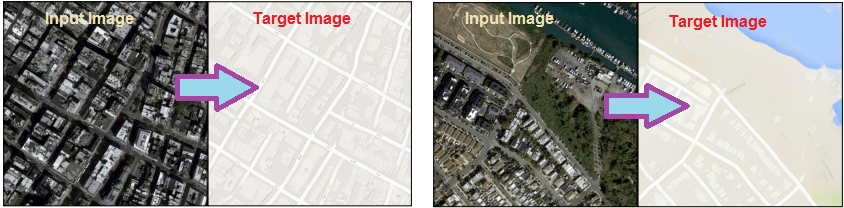

# **Inspired by https://arxiv.org/pdf/1611.07004.pdf I am going to solve this problem**
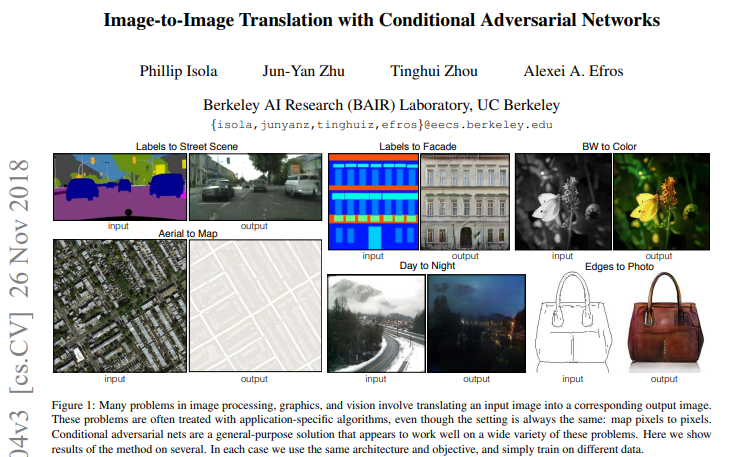

# **Important points from the article:**

1) "for our generator we use a **“U-Net”-based architecture**, and for our discriminator we use a convolutional **“PatchGAN” classifier**"

2) "we apply the **Adam solver** with a learning rate of 0.0002 and momentum parameters β1 = 0.5, β2 = 0.999"

3) "**the batch size is set to 1**, has been demonstrated to be effective at image generation tasks"

4) **Minimax game** looks like:

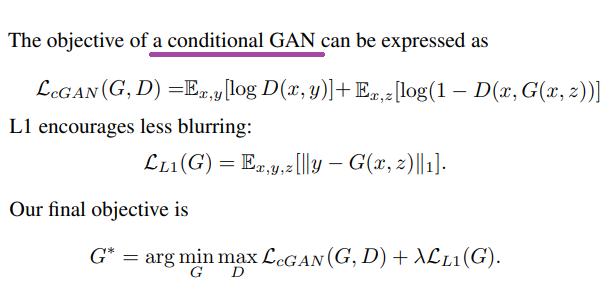

5) **What are patches? How many patches do we need?**
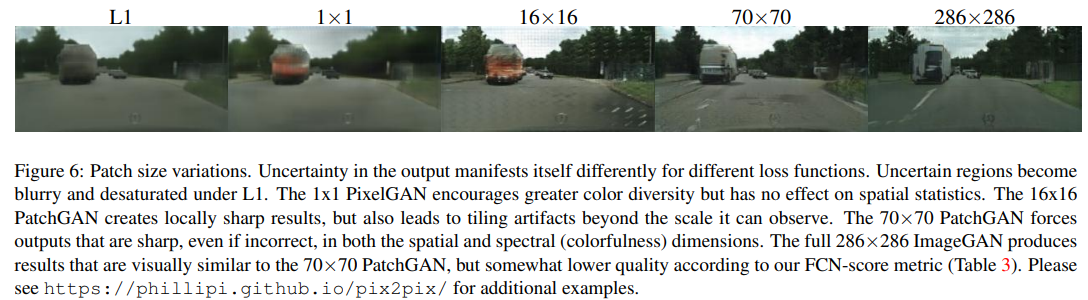

6) **Why do we use L1+cGAN loss (lambda=100)?**

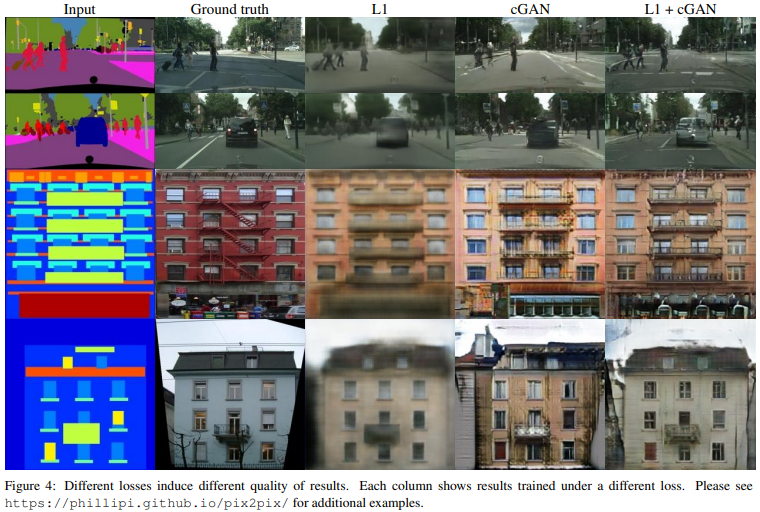

7) **How do the generator and discriminator look like?**
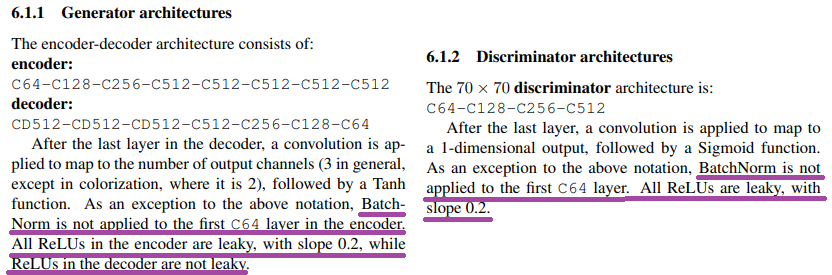

# **Useful tutorials:**

1. https://www.tensorflow.org/tutorials/generative/pix2pix
2. https://www.youtube.com/watch?v=6fp4D_VaYQo (in Keras)
3. https://www.youtube.com/watch?v=SuddDSqGRzg (in PyTorch)
4. This is a famous issue, therefore there are many explanations of how to solve it. **My goal is to understand how to do it and do it by myself.**

# **Let me start!**

In [ ]:
# otherwise we have a problem: compile metrics have yet to be built
! pip uninstall tensorflow
! pip install tensorflow==2.3.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam # for compile model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from tensorflow.python.keras.models import Model, Input # because conditional GANs require the Functional API

In [3]:
# Generator = encoder + decoder

def encoder_block(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=0.02) # weight initialization
  g = Conv2D(filters=n_filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in) # add downsampling layer
  if batchnorm: # add normalization if we need
    g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g) # as in the article (see Appendix, p.16) :)
  return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  init = RandomNormal(stddev=0.02) # weight initialization
  g = Conv2DTranspose(filters=n_filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in) # add upsampling layer
  g = BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True) # as in the article (see Appendix, p.16) :)
  g = Concatenate()([g, skip_in]) # according to the article the skip connections concatenate activations from layer i to layer n − i
  g = Activation('relu')(g) # as in the article (see Appendix, p.16) :)
  return g

def build_generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02) # weight initialization
  in_image = Input(shape=image_shape)
  # Encoder rule: 64 -> 128 -> 256 -> 512 -> 512 -> 512 -> 512 
  e1 = encoder_block(in_image, 64, batchnorm=False) 
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)
  bottl = Conv2D(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7) # bottleneck
  bottl = Activation('relu')(bottl)
  # the decoder appears on the stage
  d1 = decoder_block(bottl, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # output
  g = Conv2DTranspose(filters=image_shape[2], kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g) # image in the range from -1 to 1
  # our model
  model = Model(in_image, out_image)
  return model

In [4]:
g_model = build_generator()
g_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
_______________________________________________________________________________________

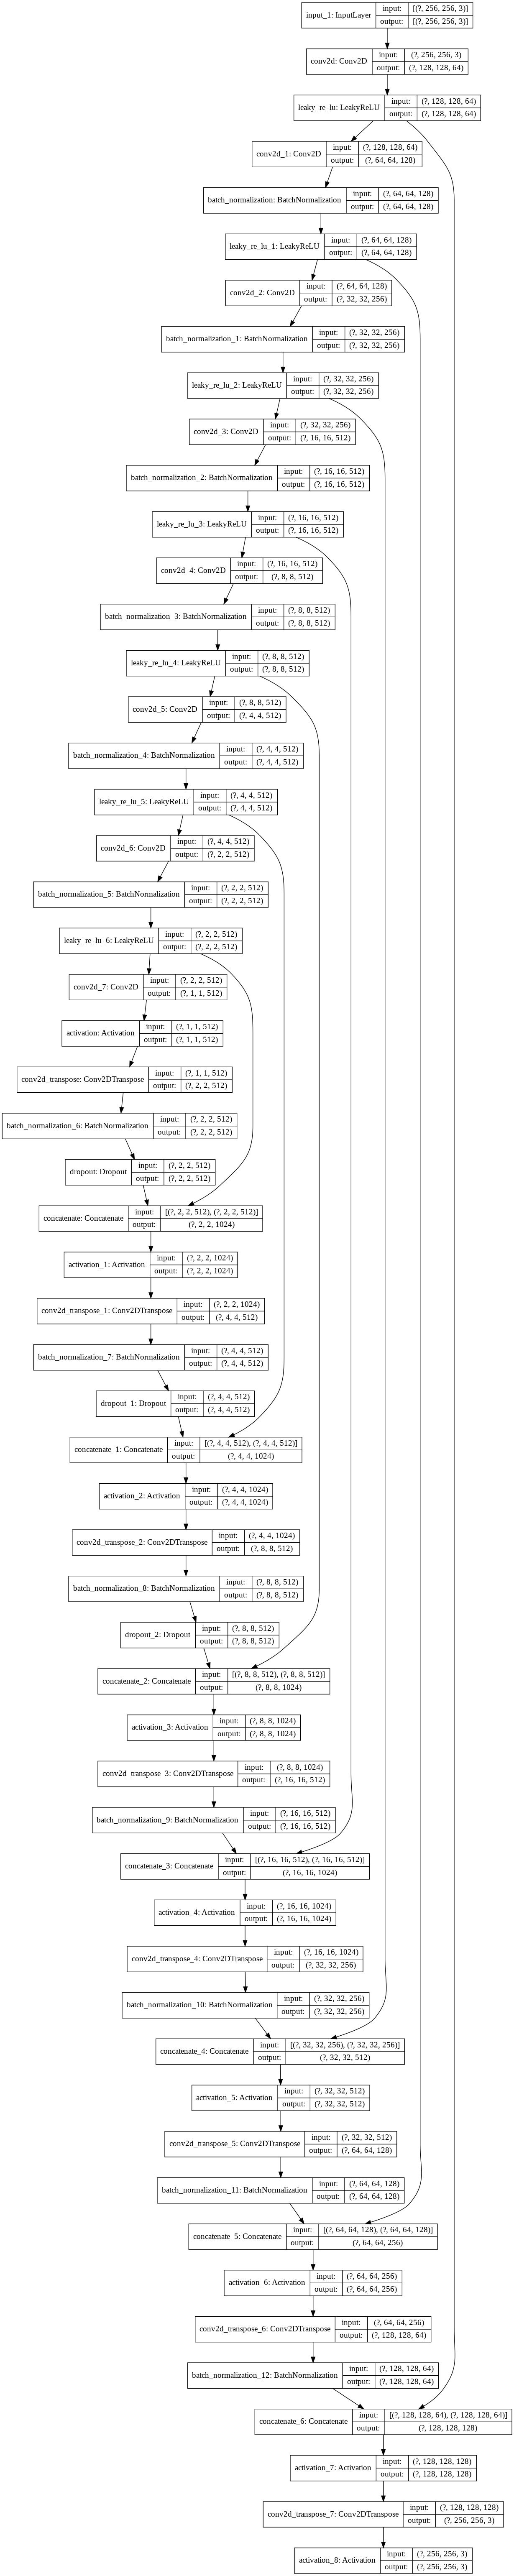

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(g_model, to_file = 'g_model.jpg', show_shapes=True)

In [6]:
def build_discriminator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02) # weight initialization
  in_image = Input(shape=image_shape)
  tar_image = Input(shape=image_shape)
  merged_images = Concatenate()([in_image, tar_image])
  # Discriminator rule: 64 -> 128 -> 256 -> 512
  d = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged_images)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(filters=512, kernel_size=(4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  d = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # our model
  model = Model([in_image, tar_image], patch_out)
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999), loss_weights=[0.5])
  return model

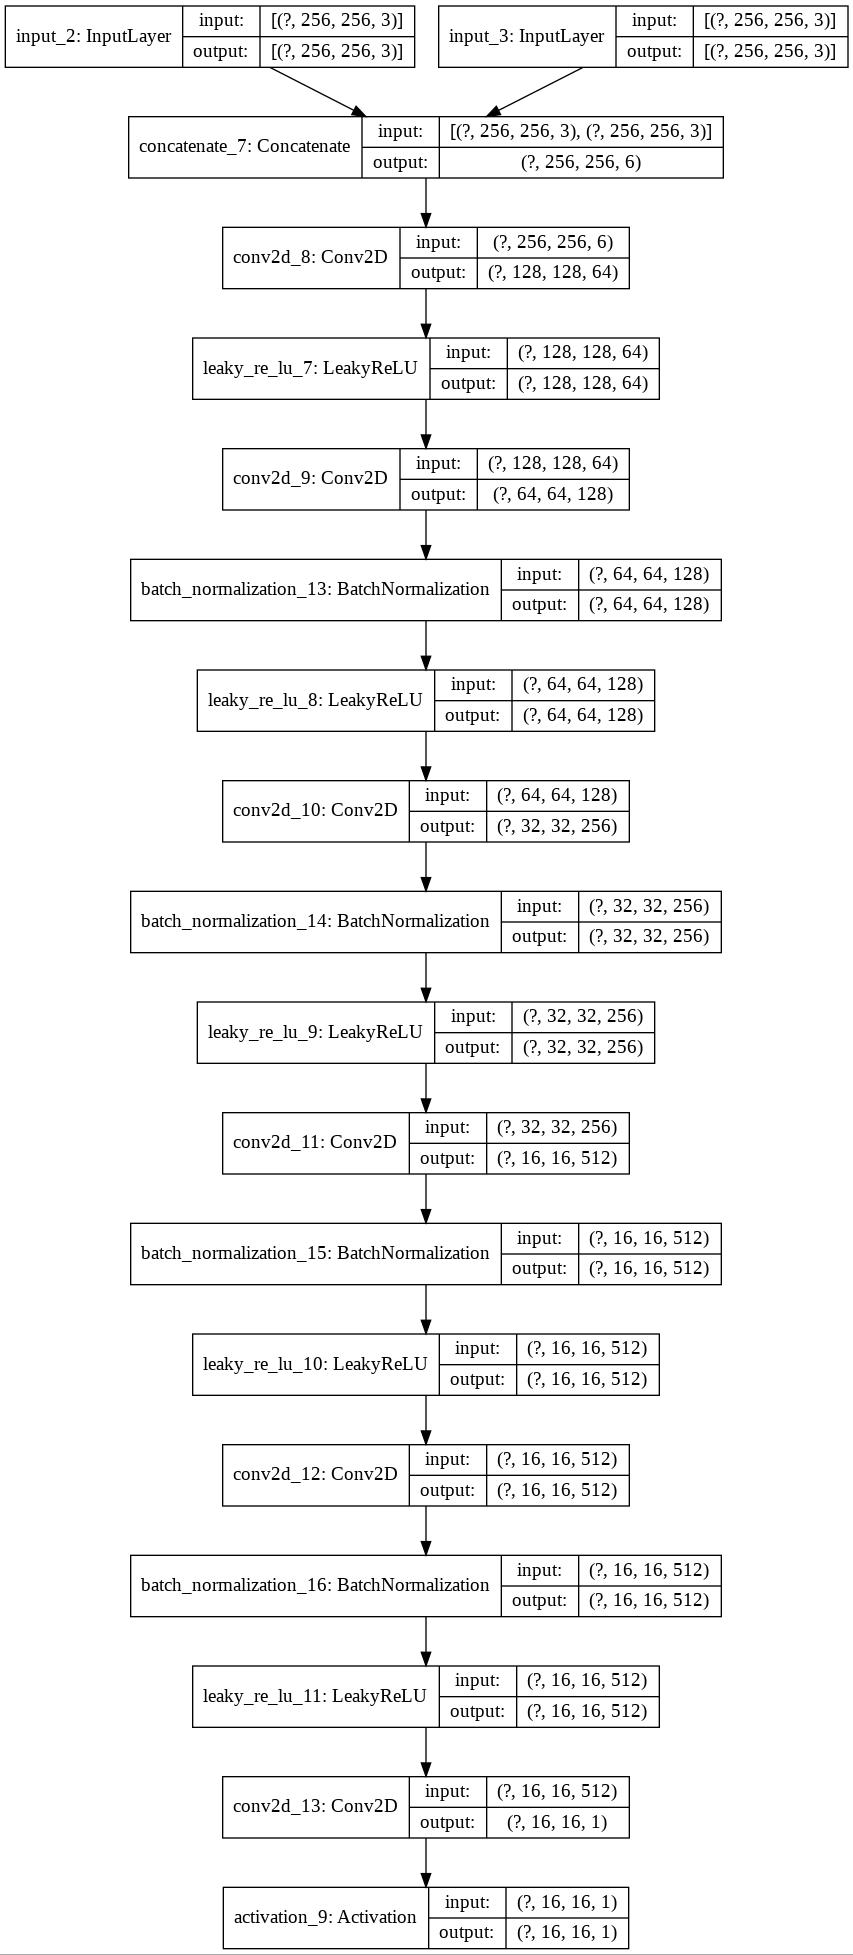

In [7]:
d_model = build_discriminator()
plot_model(d_model, to_file = 'd_model.jpg', show_shapes=True)

In [8]:
from numpy.random import randint
from numpy import zeros, ones

def build_gan(g_model, d_model, image_shape):
  d_model.trainable = False # weights in discriminator not trainable (for train generator's weights)
  in_image = Input(shape=image_shape)
  gen_out = g_model(in_image)
  dis_out = d_model([in_image, gen_out])
  model = Model(in_image, [dis_out, gen_out])
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999), loss_weights=[1,100])
  return model

def generate_real_samples(dataset, n_samples, patch_shape):
  trainA, trainB = dataset
  ix = randint(0, trainA.shape[0], n_samples) # choose random instances
  x1, x2 = trainA[ix], trainB[ix] # retrieve selected images
  y = ones((n_samples, patch_shape, patch_shape, 1)) # real images labeled 1
  return [x1, x2], y

def generate_fake_samples(g_model, samples, patch_shape):
  x = g_model.predict(samples)
  y = zeros((len(x), patch_shape, patch_shape, 1)) # fake images labeled 0
  return x, y

gan_model = build_gan(g_model, d_model, (256,256,3))

In [9]:
# We want to find a balance between the generator and the discriminator, thereby we need to see how good generated images look. Also I want to save model
def model_summarize(step, g_model, dataset, n_samples=3):
  [x_realA, x_realB], _ = generate_real_samples(dataset, n_samples, 1)
  x_fakeB, _ = generate_fake_samples(g_model, x_realA, 1)
  # scaling all pixels from [-1, 1] to [0, 1]
  x_realA = (x_realA+1) / 2.0
  x_realB = (x_realB+1) / 2.0
  x_fakeB = (x_fakeB+1) / 2.0
  for i in range(n_samples):
    plt.subplot(3, n_samples, i+1)
    plt.axis('off')
    plt.imshow(x_realA[i])
  for i in range(n_samples):
    plt.subplot(3, n_samples, i+1+n_samples)
    plt.axis('off')
    plt.imshow(x_fakeB[i])
  for i in range(n_samples):
    plt.subplot(3, n_samples, i+1+n_samples*2)
    plt.axis('off')
    plt.imshow(x_realB[i])
  plot_file = 'plot_%06d.png' % (step+1)
  plt.savefig(plot_file)
  plot_file = "/content/drive/MyDrive/lab5_part2_result/" + plot_file
  plt.savefig(plot_file)
  plt.close()
  model_file = 'model_for_maps_%06d.h5' % (step+1)
  g_model.save(model_file, include_optimizer=True)
  model_file = "/content/drive/MyDrive/lab5_part2_result/" + model_file
  g_model.save(model_file, include_optimizer=True)

In [10]:
generator_losses = []
discriminator_losses_real = []
discriminator_losses_fake = []

def train_model(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA)/n_batch)
  n_steps = batch_per_epoch * n_epochs
  for i in range(n_steps):
    [x_realA, x_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    x_fakeB, y_fake = generate_fake_samples(g_model, x_realA, n_patch)
    d_loss_real = d_model.train_on_batch([x_realA, x_realB], y_real)
    d_loss_fake = d_model.train_on_batch([x_realA, x_fakeB], y_fake)
    g_loss, _, _ = gan_model.train_on_batch(x_realA, [y_real, x_realB])
    generator_losses.append(g_loss)
    discriminator_losses_real.append(d_loss_real)
    discriminator_losses_fake.append(d_loss_fake)
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss_real, d_loss_fake, g_loss))
    if (i+1) % 1 == 0:
      model_summarize(i, g_model, dataset)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
DATA_train_DIR = "/content/drive/MyDrive/maps/train/"
DATA_test_DIR = "/content/drive/MyDrive/maps/test/"

In [13]:
from os import listdir
from numpy import asarray, savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256, 512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]


# load dataset
[src_images, tar_images] = load_images(DATA_train_DIR)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

# load the prepared dataset
from numpy import load
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz
Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = build_discriminator(image_shape)
g_model = build_generator(image_shape)
gan_model = build_gan(g_model, d_model, image_shape)
# train model
n_epochs = 100
train_model(d_model, g_model, gan_model, dataset, n_epochs)

Text(0, 0.5, 'discriminator loss on the fake images')

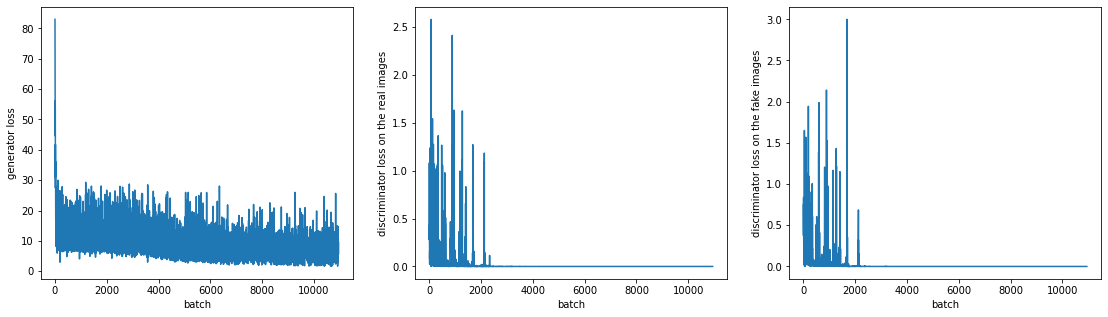

In [15]:
fig = plt.figure(figsize=(19, 5))
ax1 = fig.add_subplot(131)
plt.plot(generator_losses)
plt.xlabel('batch')
plt.ylabel('generator loss')
ax2 = fig.add_subplot(132)
plt.plot(discriminator_losses_real)
plt.xlabel('batch')
plt.ylabel('discriminator loss on the real images')
ax3 = fig.add_subplot(133)
plt.plot(discriminator_losses_fake)
plt.xlabel('batch')
plt.ylabel('discriminator loss on the fake images')

In [51]:
from numpy import vstack
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	for i in range(len(images)):
		plt.subplot(1, 3, 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()


[src_images_test, tar_images_test] = load_images(DATA_test_DIR)
filename = 'maps_test_256.npz'
savez_compressed(filename, src_images, tar_images)
test_dataset = load_real_samples('maps_test_256.npz')

In [52]:
from tensorflow.python.keras.models import load_model
model = load_model('model_for_maps_010500.h5')

Result on train data:


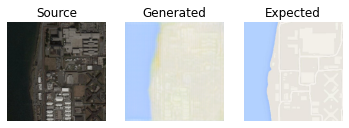

In [74]:
[x1, x2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = x1[ix], x2[ix]
gen_image = model.predict(src_image)
# plot all three images
print("Result on train data:")
plot_images(src_image, gen_image, tar_image)

Result on test data:


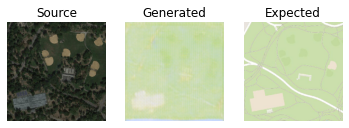

In [77]:
[x1, x2] = test_dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = x1[ix], x2[ix]
gen_image = model.predict(src_image)
# plot all three images
print("Result on test data:")
plot_images(src_image, gen_image, tar_image)

**More epochs are needed for the best result. Below are the images of how the model trained.**

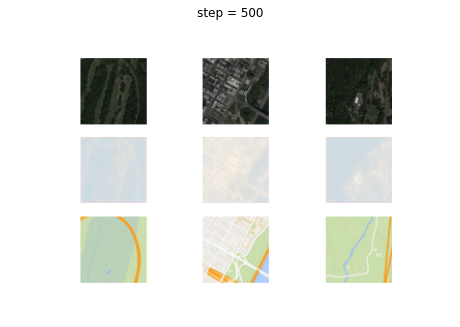

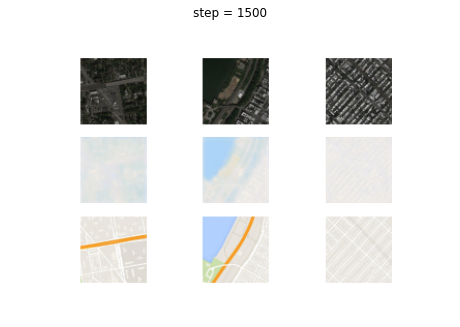

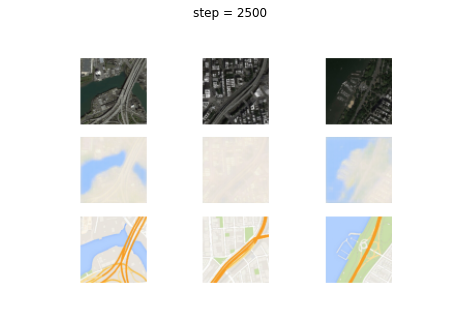

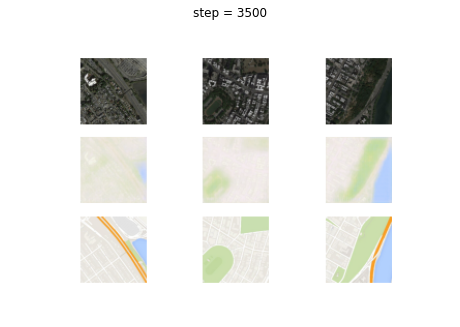

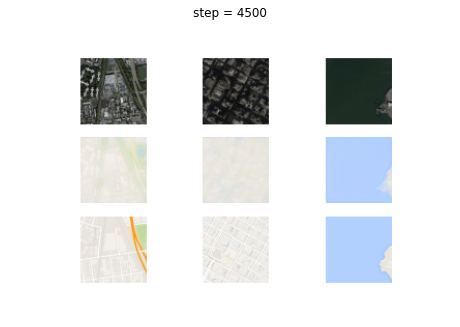

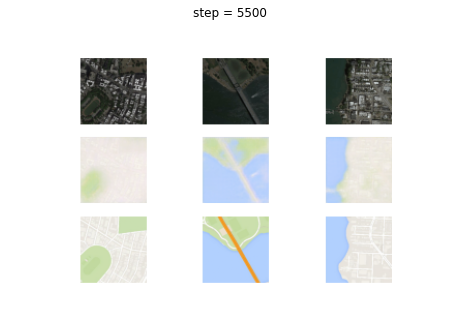

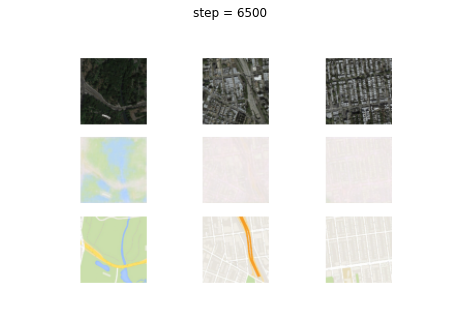

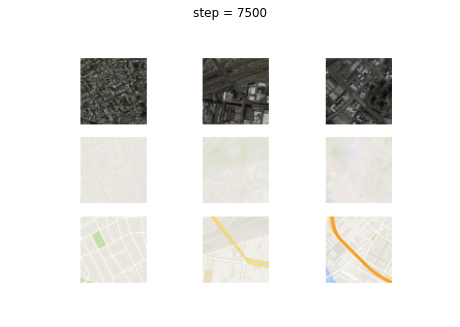

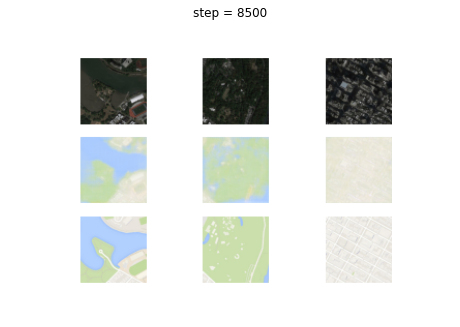

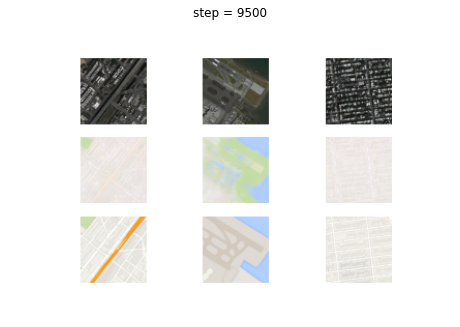

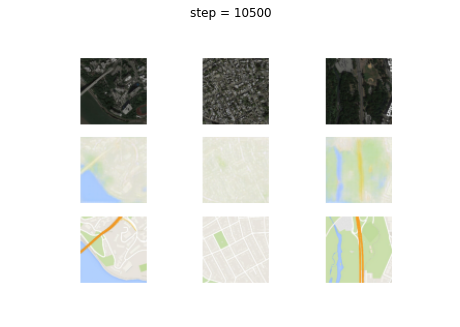

In [81]:
for i in range(500, 10501, 1000):
  image_file = 'plot_%06d.png' % i
  image_file = "/content/drive/MyDrive/lab5_part2_result/" + image_file
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)
  # Convert both image to float32 tensor
  image = tf.cast(image, tf.float32)
  plt.figure(figsize=(8,8))
  plt.imshow(image / 255.0)
  plt.axis('off')
  plt.title('step = %i' %i)